#### Approach: 
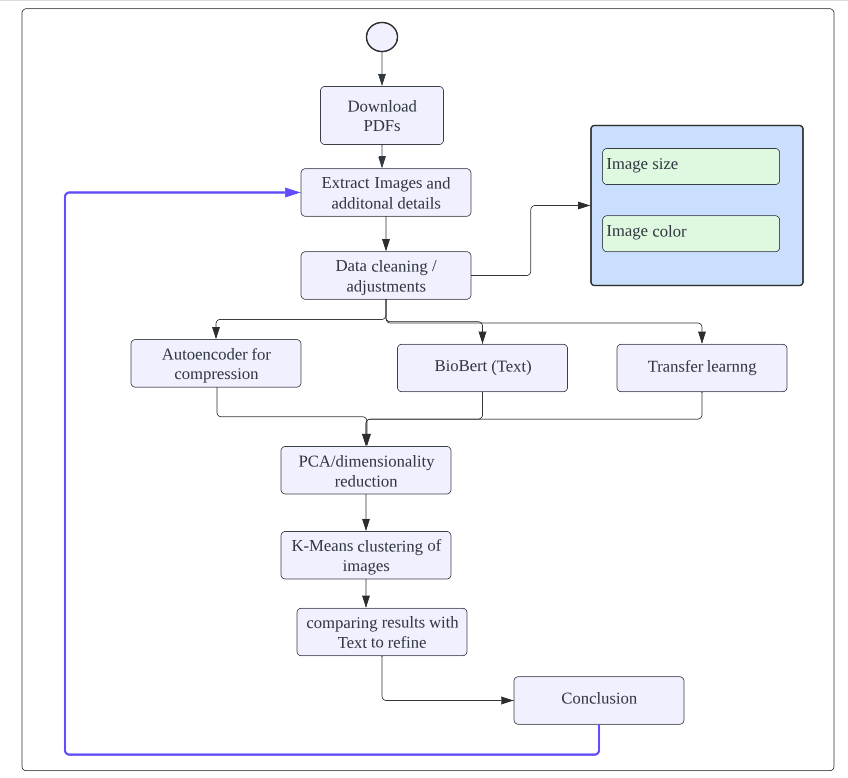

In [ ]:
!pip install PyMuPDF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.0 MB 2.3 MB/s 


In [1]:
# Connect to google drive 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# cp drive/MyDrive/Colab_Notebooks/data/project/* . 
# unzip processed_128.zip

Mounted at /content/drive


In [ ]:
# Import
import warnings
import os, random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

# PyMuPDF 
import fitz
import io
from PIL import Image
from bs4 import BeautifulSoup

import json
import re
import os

# image processing 
import skimage.io as skio
import skimage.transform as sktran
from skimage import color

####<font color="blue">Dataset generation</font>

> <font color="red"> This section is for dataset generation. So, Please do not run on Colab. This work was done on local machine.</font>

In [ ]:
base_path = "/Volumes/T7/data/oa_pdf/"
test_file_path = "data/test/"
pubmed_path = "pub/pmc/oa_pdf"
local_path = "/Volumes/T7/data"

In [ ]:
total_files = 0 
for root, dirs, files in os.walk(base_path):
    if root == base_path:
        continue
    
    for file in files:
            if file.endswith(".pdf"):
                total_files = total_files + 1

print(f"Total PDF files: {total_files: ,}")

Total PDF files:  168,623


In [ ]:
processed_df = pd.read_csv('dataset.txt', '\t')

In [ ]:
processed_file_path = 'processed/'
converted_file_path = 'processed_128/'
width=128
height=128

In [ ]:
fail_images_count = 0
for root, dirs, files in os.walk(base_path):
    dataset_info = []
    if root == base_path:
        continue
        
    print(f"path: {root}")
    #if processed_df.shape[0] > 0 and processed_df[processed_df['pubmed_path'] == root.replace(local_path, pubmed_path)].shape[0] > 0:
    #    continue
        
    if len(files) > 1:
        for file in files:
            if file.endswith(".pdf"):
                path = root + "/" + file
                try:
                    pdf_file = fitz.open(path)

                    images = []
                    for page_index in range(len(pdf_file)):

                        page = pdf_file[page_index]
                        image_details = page.get_image_info(xrefs=True)

                        json_data = page.get_text("json")
                        json_object = json.loads(json_data)
                        for image_info in image_details:
                            image_block_number = image_info['number']
                            text_block_number = image_block_number + 1

                            texts = []
                            for block in json_object["blocks"]:
                                if block['number'] == text_block_number and 'lines' in block.keys():
                                    for line in block['lines']:
                                        for span in line['spans']:
                                            texts.append(span['text'])

                            text = " ".join(texts)
                            
                            # if text contains (a) or ( A ) or (A) or (A, text) -- complex image. ignore. 
                            simple_image = True
                            if re.search(r'\(\s*[aA]\s*', text):
                                simple_image = False
                            
                            if 'fig' in text.lower() and simple_image:
                                xref = image_info['xref']
                                pix = fitz.Pixmap(pdf_file, xref)
                                image_filename = file.replace('.pdf', '')
                                file_name = f"{image_filename}_{page_index+1}_{xref}.jpg"
                                file_path = processed_file_path + file_name
                                pix.save(file_path)
                                image_details = {'pubmed_path': root.replace(local_path, pubmed_path), 'pdf': file,  'image': file_name, 'image_path': file_path, 'text': text}
                                dataset_info.append(image_details)
                                try:
                                    img = skio.imread(file_path)
                                    img = color.rgb2gray(img)
                                    resized_image = sktran.resize(img, (width, height), anti_aliasing=True)
                                    target_file = converted_file_path + file_name
                                    skio.imsave(target_file, (resized_image * 255).astype(np.uint8), check_contrast=False)
                                except error:
                                    fail_images_count = fail_images_count + 1
                                
                except (fitz.FileDataError, ValueError, RuntimeError) as error :
                    #print(f"   File not processed {path}")
                    fail_images_count = fail_images_count + 1
    if len(dataset_info) > 0:
        dataset_df = pd.DataFrame.from_records(dataset_info)
        if not os.path.isfile('dataset.txt'):
            dataset_df.to_csv('dataset.txt', '\t', index=False, header='column_names')
        else: # else it exists so append without writing the header
            dataset_df.to_csv('dataset.txt', '\t', index=False, mode='a', header=False)